<a href="https://colab.research.google.com/github/scott-cjx/1015-Project/blob/main/1015_WeatherTaxi_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from datetime import datetime
import requests

In [ ]:
URI_CONSOL_TAXI_1HR = "https://raw.githubusercontent.com/scott-cjx/1015-Project/main/data/consolidated_taxi_1hour.csv"
URI_CONSOL_TAXI = "https://raw.githubusercontent.com/scott-cjx/1015-Project/main/data/consolidated_taxi_data.csv"

In [ ]:
def get_df_from_rawgit(url):
  df = pd.read_csv(url)
  return df

df_raw = get_df_from_rawgit(URI_CONSOL_TAXI_1HR)
df = df_raw.copy()

df.rename(columns={'Count':'TAXI_AVAILABLE'}, inplace=True)

# set hour as time
df["HOUR"] = df["TIME"].astype(str).apply(lambda x: int(x.split(":")[0]))

# set as day as day of week
df['DAY'] = pd.to_datetime(df["DATE"]).dt.day_name()

# drop time and date
df = df.drop(columns=["TIME", "DATE"])

df["HOUR"] = df["HOUR"].astype('category')

In [ ]:
# @title Intervention of FORECAST

# forecast_le = [
#     ['Fair (Night)', 'Fair (Day)', 'Fair & Warm'],
#     ['Partly Cloudy (Night)', 'Partly Cloudy (Day)'],
#     ['Cloudy'],
#     ['Showers', 'Light Showers', 'Thundery Showers', 'Heavy Thundery Showers']
# ]

forecast_le = [
    ['Fair (Night)', 'Fair (Day)', 'Fair & Warm'],
    ['Partly Cloudy (Night)', 'Partly Cloudy (Day)', 'Cloudy'],
    ['Showers', 'Light Showers', 'Thundery Showers', 'Heavy Thundery Showers']
]

df['FORECAST_FILTERED'] = df.apply(lambda row: next((i for i, group in enumerate(forecast_le) if row['FORECAST'] in group), len(forecast_le)), axis=1)
df['FORECAST_FILTERED'] = df['FORECAST_FILTERED'].astype("category")

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

df_le = df.copy()
df_le['AREA_LE'] = le.fit_transform(df_le['AREA'])
df_le['DAY_LE'] =  le.fit_transform(df_le['DAY'])

df_le['DAY_LE'] = df_le['DAY_LE'].astype('category')
df_le['AREA_LE'] = df_le['AREA_LE'].astype('category')

df_le = df_le.drop(columns=['FORECAST', "AREA", "DAY"], errors="ignore")

In [ ]:
df_le.head()

,TAXI_AVAILABLE,HOUR,FORECAST_FILTERED,AREA_LE,DAY_LE
0,136,0,0,0,0
1,211,0,0,1,0
2,70,0,0,2,0
3,5,0,0,3,0
4,129,0,0,4,0


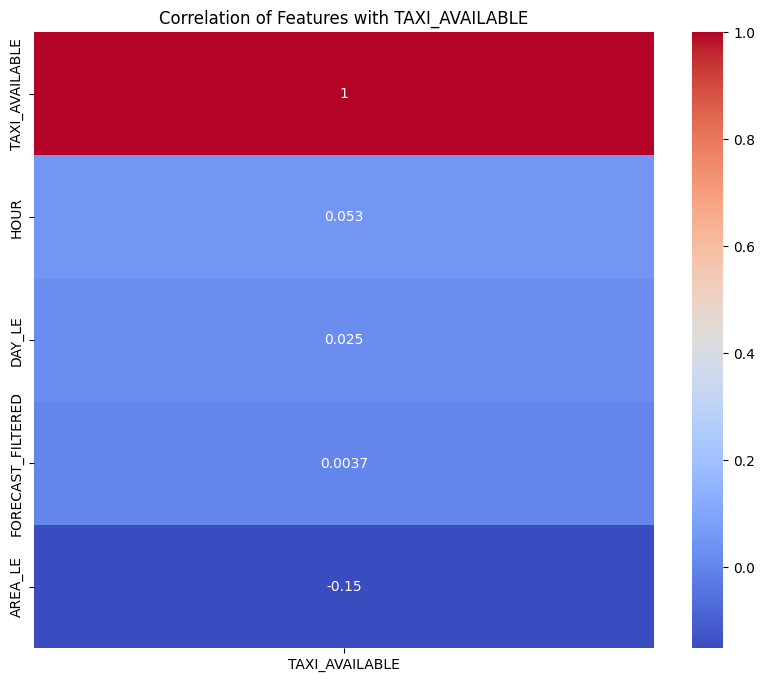

In [ ]:
# prompt: show the corelation of all the items in df_le_clean to TAXI_AVAILABLE and plot on heatmap

import seaborn as sns

corr = df_le.corr()

# Select the columns related to TAXI_AVAILABLE
corr_with_target = corr["TAXI_AVAILABLE"].sort_values(ascending=False)

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_with_target.to_frame(), annot=True, cmap="coolwarm")
plt.title("Correlation of Features with TAXI_AVAILABLE")
plt.show()


In [ ]:
df_le.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21482 entries, 0 to 21481
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   TAXI_AVAILABLE     21482 non-null  int64   
 1   HOUR               21482 non-null  category
 2   FORECAST_FILTERED  21482 non-null  category
 3   AREA_LE            21482 non-null  category
 4   DAY_LE             21482 non-null  category
dtypes: category(4), int64(1)
memory usage: 254.5 KB


In [ ]:
areas = df["AREA"].unique()
areas

array(['Ang Mo Kio', 'Bedok', 'Bishan', 'Boon Lay', 'Bukit Batok',
       'Bukit Merah', 'Bukit Panjang', 'Bukit Timah',
       'Central Water Catchment', 'Changi', 'Choa Chu Kang', 'City',
       'Clementi', 'Geylang', 'Hougang', 'Jalan Bahar', 'Jurong East',
       'Jurong Island', 'Jurong West', 'Kallang', 'Mandai',
       'Marine Parade', 'Novena', 'Pasir Ris', 'Paya Lebar', 'Pioneer',
       'Pulau Ubin', 'Punggol', 'Queenstown', 'Seletar', 'Sembawang',
       'Sengkang', 'Sentosa', 'Serangoon', 'Sungei Kadut', 'Tampines',
       'Tanglin', 'Tengah', 'Toa Payoh', 'Tuas', 'Woodlands', 'Yishun',
       'Lim Chu Kang', 'Western Water Catchment'], dtype=object)

In [ ]:
df_le[["TAXI_AVAILABLE"]].describe()

,TAXI_AVAILABLE
count,21482.000000
mean,173.589191
std,199.790210
min,1.000000
25%,39.000000
50%,123.000000
75%,238.000000
max,3132.000000


In [ ]:
# @title Outlier intervention

Q1 = df_le["TAXI_AVAILABLE"].quantile(0.25)
Q3 = df_le["TAXI_AVAILABLE"].quantile(0.75)
IQR = Q3 - Q1

upper_bound = Q3 + 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR

df_le_clean = df_le.copy()
df_le_clean = df_le_clean[df_le_clean["TAXI_AVAILABLE"] <= upper_bound]
df_le_clean = df_le_clean[df_le_clean["TAXI_AVAILABLE"] >= lower_bound]

In [ ]:
df_le_clean.describe()

,TAXI_AVAILABLE
count,20550.000000
mean,141.678929
std,120.564811
min,1.000000
25%,35.000000
50%,113.000000
75%,222.000000
max,536.000000


In [ ]:
# @title Outlier Intervention (Old)

# df[df["TAXI_AVAILABLE"] > 1500].describe()
# df_query = df
# df_query = df_query[df_query["TAXI_AVAILABLE"] < 700]
# df_query = df_query[df_query["AREA"] != 'Changi']
# df_query

# df_query2 = df
# df_query2[df_query2["AREA"] == 'Changi']
# df_query2.describe()

# df_query.info()

# df = df_query
# df.info()

In [ ]:
df_le_clean.describe()

,TAXI_AVAILABLE
count,20550.000000
mean,141.678929
std,120.564811
min,1.000000
25%,35.000000
50%,113.000000
75%,222.000000
max,536.000000


# Exploratory Data Analysis

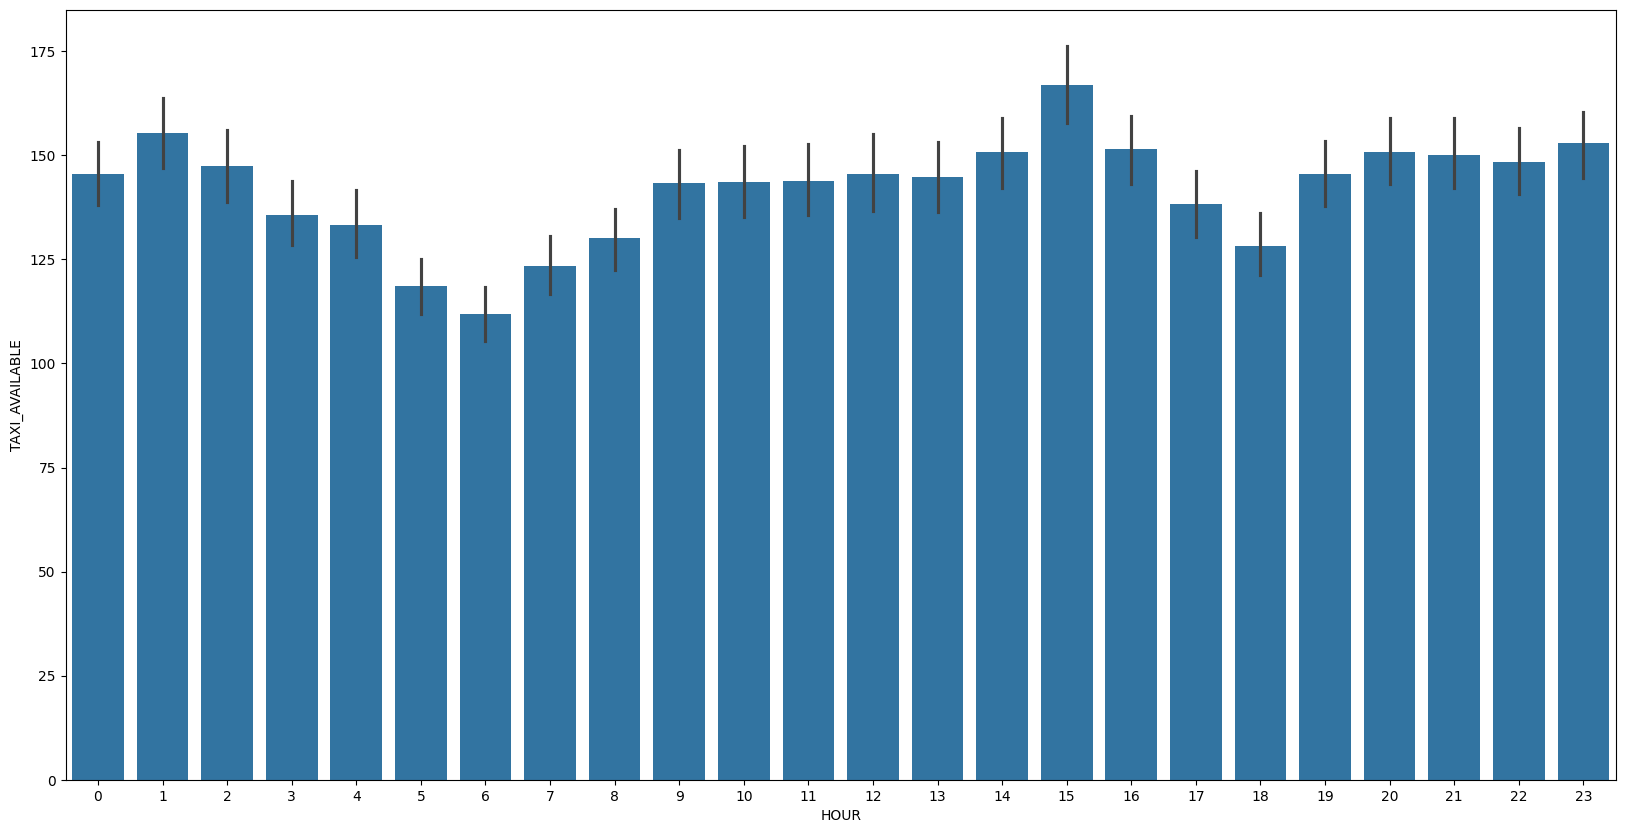

In [ ]:
# @title HOUR vs TAXI_AVAILABLE

fig, ax = plt.subplots(figsize=(20, 10))

df_sorted = df_le_clean.sort_values('HOUR', ascending=True)
sb.barplot(df_sorted, x="HOUR", y='TAXI_AVAILABLE')

_ = plt.xlabel('HOUR')
_ = plt.ylabel('TAXI_AVAILABLE')

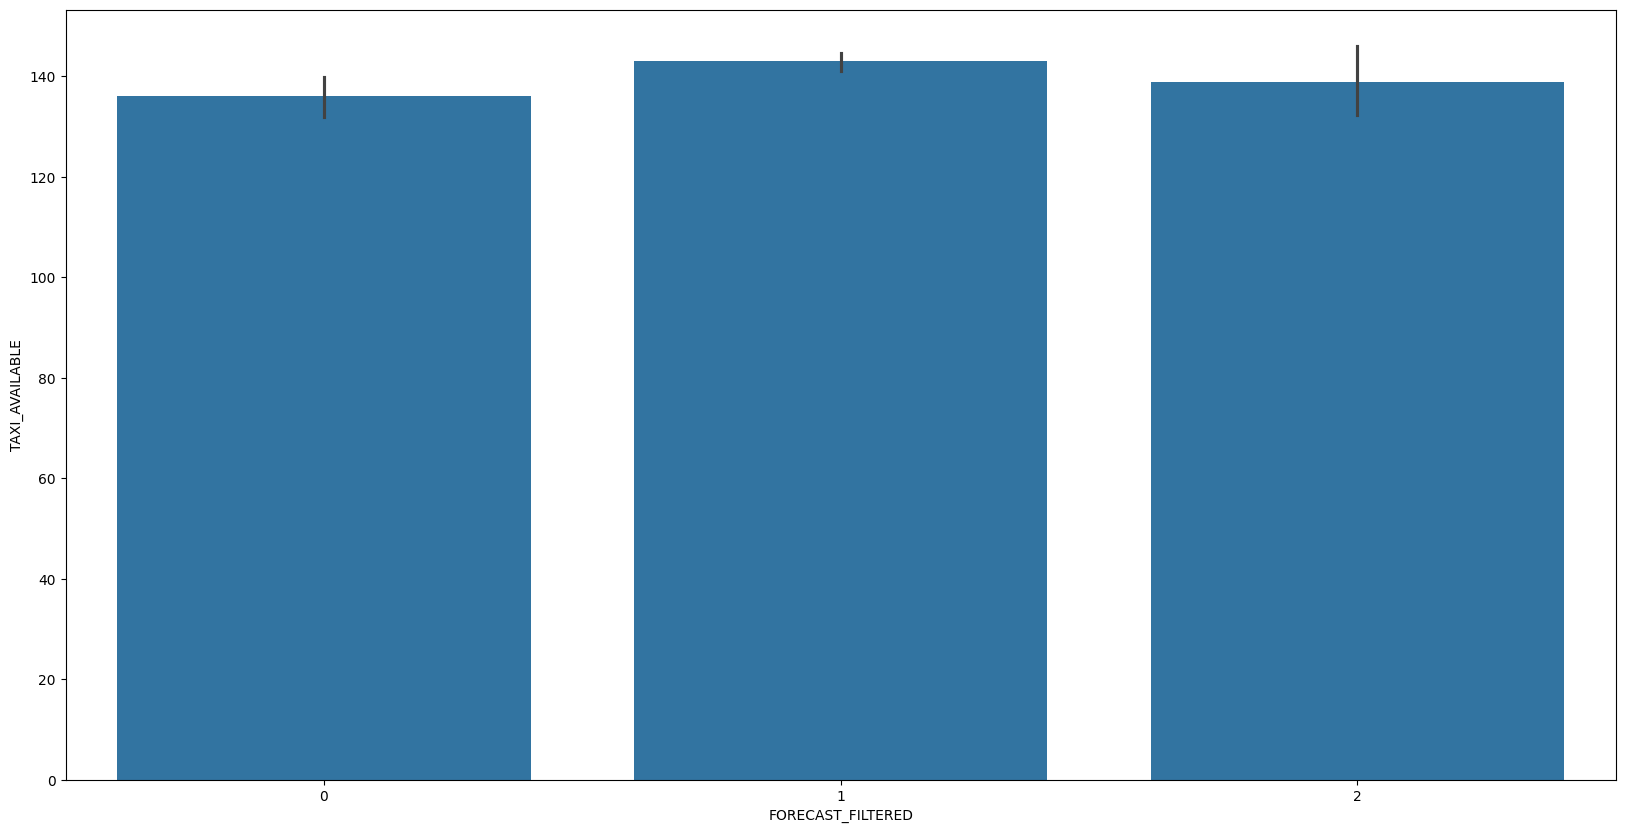

In [ ]:
# @title FORECAST vs TAXI_AVAILABLE

fig, ax = plt.subplots(figsize=(20, 10))

df_sorted = df_le_clean.sort_values('FORECAST_FILTERED', ascending=True)
sb.barplot(df_sorted, x="FORECAST_FILTERED", y='TAXI_AVAILABLE')

_ = plt.xlabel('FORECAST_FILTERED')
_ = plt.ylabel('TAXI_AVAILABLE')

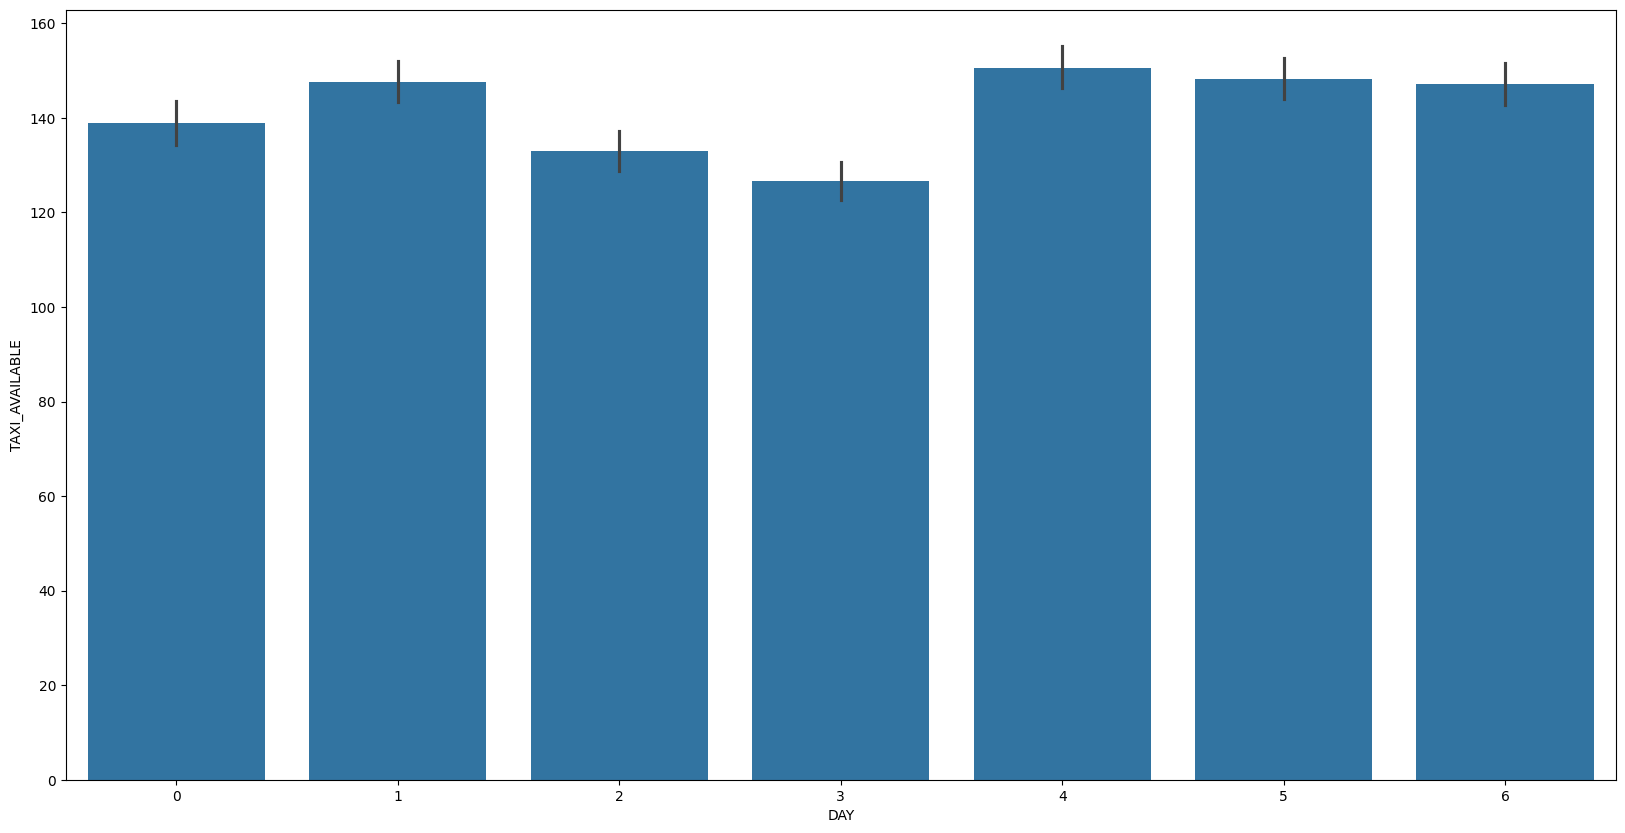

In [ ]:
# @title DAY vs TAXI_AVAILABLE

fig, ax = plt.subplots(figsize=(20, 10))

df_sorted = df_le_clean.sort_values('DAY_LE', ascending=True)
sb.barplot(df_sorted, x="DAY_LE", y='TAXI_AVAILABLE')

_ = plt.xlabel('DAY')
_ = plt.ylabel('TAXI_AVAILABLE')

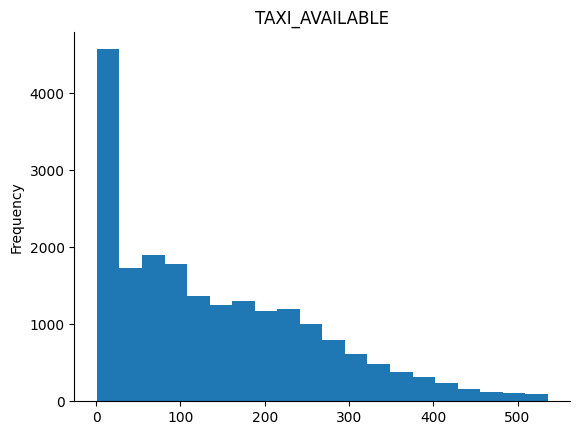

In [ ]:
# @title TAXI_AVAILABLE

from matplotlib import pyplot as plt
df_le_clean['TAXI_AVAILABLE'].plot(kind='hist', bins=20, title='TAXI_AVAILABLE')
plt.gca().spines[['top', 'right',]].set_visible(False)

score:  0.008976178707417737


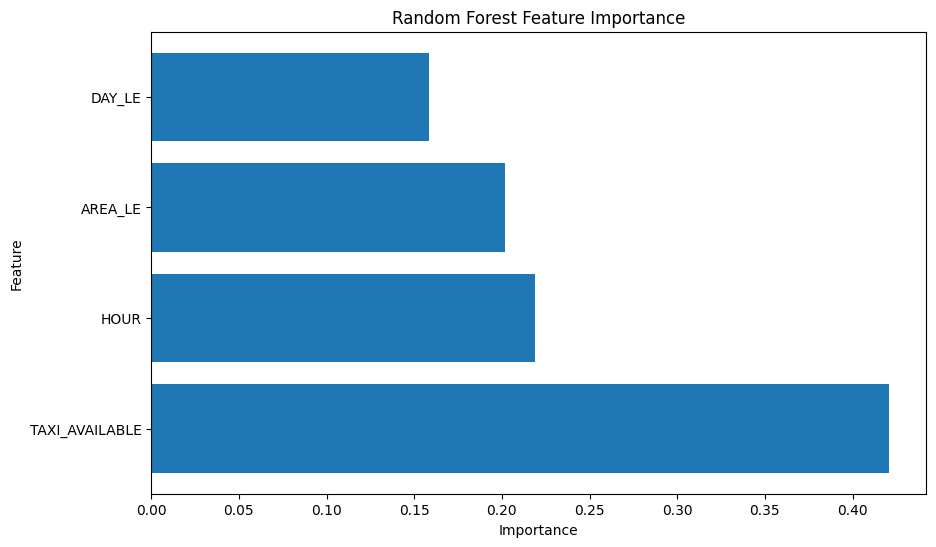

In [ ]:
# @title RandomForestRegressor model to predict FORECAST_FILTERED

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

df2 = df_le_clean.copy()
y = df2["FORECAST_FILTERED"]
X = df2.drop(columns=["FORECAST_FILTERED"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

model = RandomForestRegressor(n_estimators=100, random_state=0)
model.fit(X_train, y_train)

print('score: ', model.score(X_test, y_test))

importances = model.feature_importances_
features = X.columns

plt.figure(figsize=(10, 6))
plt.barh(features, importances, align='center')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importance')
plt.show()


In [ ]:
# @title convert df's TAXI_AVAILABLE to categorical via ranges of 50

# deprecated

# df['TAXI_AVAILABLE_CAT'] = pd.cut(df['TAXI_AVAILABLE'], bins=np.arange(0, 1550, 50), labels=False)
# df.head()


In [ ]:
from IPython.display import SVG
from graphviz import Source
from sklearn import tree

def viz_tree(model):
  graph = Source(tree.export_graphviz(model, out_file=None, feature_names=X.columns))
  return SVG(graph.pipe(format='svg'))

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def show_cm(model, X_test, y_test):
  predictions = model.predict(X_test)
  cm = confusion_matrix(y_test, predictions, labels=model.classes_)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
  disp.plot()

In [ ]:
# @title DecisionTreeClassifier to predict TAXI_AVAILABLE

# this is deprecated, we cannot use a Classifier on a Numerical predictee^^

# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
# from sklearn.tree import DecisionTreeClassifier
# from sklearn import tree

# df2 = df_le_clean.copy()
# y = df2["TAXI_AVAILABLE"]
# X = df2.drop(columns=["TAXI_AVAILABLE"])

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# dtc_TAXIA_model = DecisionTreeClassifier(max_depth=10)
# dtc_TAXIA_model.fit(X_train, y_train)

# print('score: ', dtc_TAXIA_model.score(X_test, y_test))

# # we wont plot this, score is too low to be worth the time
# # show_cm(dtc_TAXIA_model,  X_test, y_test)

score:  0.79408330089529


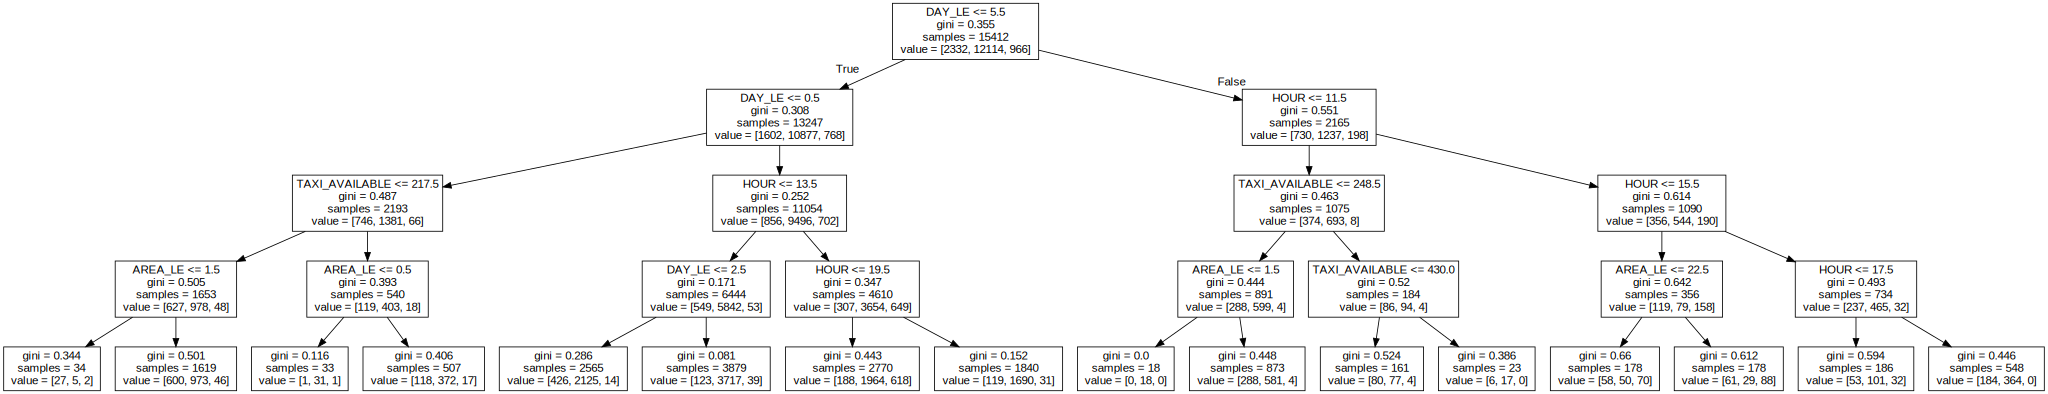

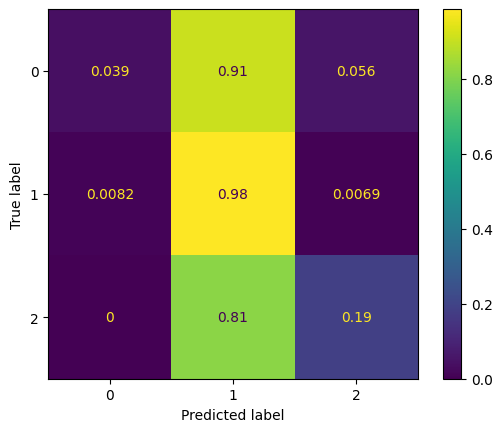

In [ ]:
# @title DecisionTreeClassifier to predict FORECAST

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

df2 = df_le_clean.copy()
y = df2["FORECAST_FILTERED"]
X = df2.drop(columns=["FORECAST_FILTERED"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

dtc_forecast_model = DecisionTreeClassifier(max_depth=4)
dtc_forecast_model.fit(X_train, y_train)

print('score: ', dtc_forecast_model.score(X_test, y_test))

predictions = dtc_forecast_model.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=dtc_forecast_model.classes_)

# normalise CM
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=dtc_forecast_model.classes_)
disp.plot()

graph = Source(tree.export_graphviz(dtc_forecast_model, out_file=None, feature_names=X.columns))
SVG(graph.pipe(format='svg'))

# tree.plot_tree(dtc_forecast_model)


In [ ]:
# @title use Neural Network to predict for TAXI_AVAILABLE

import tensorflow as tf
from sklearn.metrics import r2_score

df2 = df_le_clean.copy()
y = df2["TAXI_AVAILABLE"]
X = df2.drop(columns=["TAXI_AVAILABLE"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)


dnn_taxiavail_model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

dnn_taxiavail_model.compile(optimizer='adam', loss='mse', metrics=['mse'])
dnn_taxiavail_model.fit(X_train, y_train, epochs=50)
dnn_taxiavail_model.evaluate(X_test, y_test)


In [ ]:
# @title use Neural Network to predict for FORECAST_FILTERED

df2 = df_le_clean.copy()
y = df2["FORECAST_FILTERED"]
X = df2.drop(columns=["FORECAST_FILTERED"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)


dnn_forecast = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(len(set(y_train)))
])

dnn_forecast.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
dnn_forecast.fit(X_train, y_train, epochs=50)
dnn_forecast.evaluate(X_test, y_test)

In [ ]:
# @title use Neural Network to predict for AREA_LE

df2 = df_le_clean.copy()
y = df2["AREA_LE"]
X = df2.drop(columns=["AREA_LE"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)


dnn_forecast = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(len(set(y_train)))
])

dnn_forecast.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
dnn_forecast.fit(X_train, y_train, epochs=50)
dnn_forecast.evaluate(X_test, y_test)

In [ ]:
# @title use Neural Network to predict for DAY_LE

df2 = df_le_clean.copy()
y = df2["DAY_LE"]
X = df2.drop(columns=["DAY_LE"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)


dnn_forecast = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(len(set(y_train)))
])

dnn_forecast.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
dnn_forecast.fit(X_train, y_train, epochs=50)
dnn_forecast.evaluate(X_test, y_test)

In [ ]:
# @title use Neural Network to predict for HOUR

df2 = df_le_clean.copy()
y = df2["HOUR"]
X = df2.drop(columns=["HOUR"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)


dnn_forecast = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(len(set(y_train)))
])

dnn_forecast.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
dnn_forecast.fit(X_train, y_train, epochs=50)
dnn_forecast.evaluate(X_test, y_test)

MSE:  2652.2538605228465
R2:  0.8219488187939812


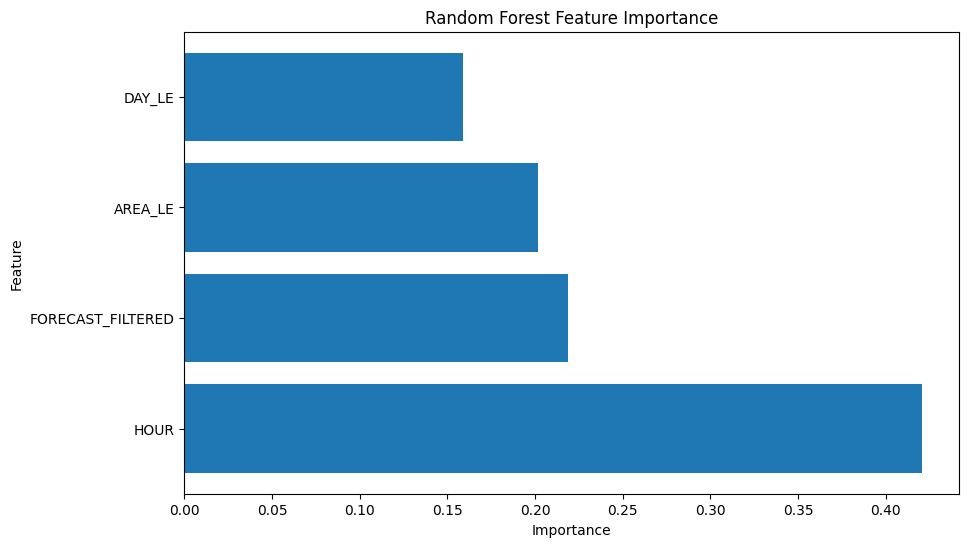

In [ ]:
# @title regression to predict TAXI_AVAILABLE
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

df2 = df_le_clean.copy()
y = df2["TAXI_AVAILABLE"]
X = df2.drop(columns=["TAXI_AVAILABLE"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

rfr_taxia_model = RandomForestRegressor(n_estimators=100, random_state=0)
rfr_taxia_model.fit(X_train, y_train)

predictions = rfr_taxia_model.predict(X_test)
r2 = r2_score(y_test, predictions)
mse = mean_squared_error(y_test, predictions)

print('MSE: ', mse)
print('R2: ', r2)


importances = model.feature_importances_
features = X.columns

plt.figure(figsize=(10, 6))
plt.barh(features, importances, align='center')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importance')
plt.show()

# cannot be plotted, too many layers

# graph = Source(tree.export_graphviz(rfr_taxia_model.estimators_[0], out_file=None, feature_names=X.columns))
# SVG(graph.pipe(format='svg'))


MSE:  3585.3187132368844
R2:  0.7593102827019631


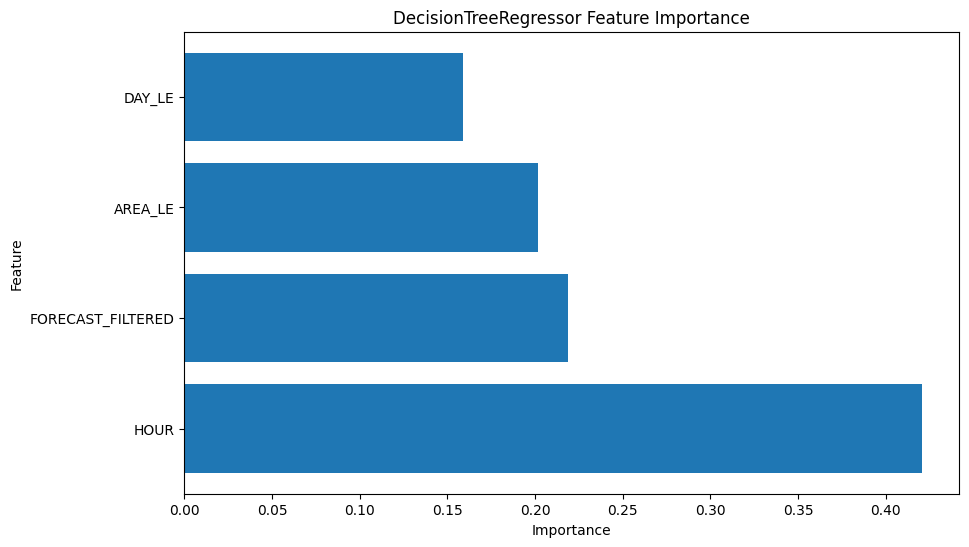

In [ ]:
# @title regression to predict TAXI_AVAILABLE
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

df2 = df_le_clean.copy()
y = df2["TAXI_AVAILABLE"]
X = df2.drop(columns=["TAXI_AVAILABLE"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

dtr_taxia_model = DecisionTreeRegressor(random_state=0)
dtr_taxia_model.fit(X_train, y_train)

predictions = dtr_taxia_model.predict(X_test)
r2 = r2_score(y_test, predictions)
mse = mean_squared_error(y_test, predictions)

print('MSE: ', mse)
print('R2: ', r2)


importances = model.feature_importances_
features = X.columns

plt.figure(figsize=(10, 6))
plt.barh(features, importances, align='center')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('DecisionTreeRegressor Feature Importance')
plt.show()
